In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score

import statsmodels.api as sm

import scipy as sp

In [2]:
# Parámetros a ajustar
ciudades = ["Palma de Mallorca", "Granada", "Almería",
            "Madrid", "Palma de Gran Canaria", "Santiago de Compostela"]
frecuencia = "Daily"
create_data_files = [False for _ in ciudades]
data_files = ["PalmaMallorca.csv", "Granada.csv", "Almeria.csv",
              "Madrid.csv", "PalmaGranCanaria.csv", "SantiagoCompostela.csv"]
SEED = 1234

In [3]:
## Combinamos todos los archivos separados en un archivo de datos ##

for (city, create, data_file) in zip(ciudades, create_data_files, data_files):
    if create:
        # Obtenemos una lista de todos los archivos CSV de esa ciudad
        csv_files = []
        for file in os.listdir():
            if ".csv" in file:
                if city in file and frecuencia in file:
                    csv_files.append(file)

        # Ordenamos la lista
        csv_files.sort()

        # Fusionamos todos los ficheros CSV
        header_printed = False
        with open(data_file, "w") as fout:
            for file in csv_files:
                with open(file, "r") as f:
                    line = f.readline()
                    if not header_printed:
                        fout.write(line)
                        header_printed = True
                    line = f.readline()
                    while line != "":
                        fout.write(line)
                        line = f.readline()

In [4]:
# Leemos toda la información
data_city = [pd.read_csv(data_file, sep=",") for data_file in data_files]
data = pd.concat([d for d in data_city])

In [5]:
useless_columns = ["icon", "stations", "description", "preciptype"]

# Eliminamos algunas columnas inútiles
for column in useless_columns:
    try:
        data = data.drop(column, axis=1)
    except KeyError:
        pass

# Desechamos las columnas con más de un cuarto de valores NaN
data = data.dropna(axis=1, thresh=0.75*len(data))

for i in range(len(data_city)):
    for column in useless_columns:
        data_city[i] = data_city[i].drop(column, axis=1)
    data_city[i] = data_city[i].dropna(axis=1, thresh=0.75*len(data_city[i]))

In [6]:
# Separamos las fechas en año, mes y día
data["year"] = data.apply(lambda row: int(row["datetime"].split("-")[0]), axis=1)
data["month"] = data.apply(lambda row: int(row["datetime"].split("-")[1]), axis=1)
data["day"] = data.apply(lambda row: int(row["datetime"].split("-")[2]), axis=1)
data = data.drop(["datetime"], axis=1)

for i in range(len(data_city)):
    data_city[i]["year"] = data_city[i].apply(lambda row: int(row["datetime"].split("-")[0]), axis=1)
    data_city[i]["month"] = data_city[i].apply(lambda row: int(row["datetime"].split("-")[1]), axis=1)
    data_city[i]["day"] = data_city[i].apply(lambda row: int(row["datetime"].split("-")[2]), axis=1)
    data_city[i] = data_city[i].drop(["datetime"], axis=1)

In [7]:
# Calculamos las horas de luz que hay cada día
datetime_format_str = "%Y-%m-%d %H:%M:%S"

data["lighthours"] = data.apply(lambda row:
    (datetime.strptime(row["sunset"].replace("T", " "), datetime_format_str) -
    datetime.strptime(row["sunrise"].replace("T", " "), datetime_format_str)).total_seconds()
    / 3600, axis=1)
data = data.drop(["sunrise", "sunset"], axis=1)

for i in range(len(data_city)):
    data_city[i]["lighthours"] = data_city[i].apply(lambda row:
    (datetime.strptime(row["sunset"].replace("T", " "), datetime_format_str) -
    datetime.strptime(row["sunrise"].replace("T", " "), datetime_format_str)).total_seconds()
    / 3600, axis=1)
    data_city[i] = data_city[i].drop(["sunrise", "sunset"], axis=1)

In [8]:
numerical = data.drop(["name", "conditions"], axis=1)
categorical = data.filter(["conditions"])

numerical_city, categorical_city = [None for _ in data_files], [None for _ in data_files]
for i in range(len(data_city)):
    numerical_city[i] = data_city[i].drop(["name", "conditions"], axis=1)
    categorical_city[i] = data_city[i].filter(["conditions"])

In [9]:
for key in numerical:
    if numerical[key].isnull().values.any():
        numerical[key] = numerical[key].fillna(numerical[key].mean())

for i in range(len(numerical_city)):
    for key in numerical_city[i]:
        if numerical_city[i][key].isnull().values.any():
            numerical_city[i][key] = numerical_city[i][key].fillna(numerical_city[i][key].mean())
numerical.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,year,month,day,lighthours
0,14.2,2.8,7.7,14.2,2.8,7.7,3.9,78.0,0.0,0,...,19.7,11.9,106.7,9.3,5.0,0.43,2015,1,1,9.428333
1,16.1,-0.2,6.2,16.1,-0.2,6.2,3.4,84.6,0.0,0,...,5.2,12.1,114.2,9.8,5.0,0.46,2015,1,2,9.440000
2,16.3,0.0,8.2,16.3,0.0,8.1,5.9,86.9,0.0,0,...,10.1,11.0,117.8,10.2,5.0,0.49,2015,1,3,9.452778
3,17.9,4.6,10.0,17.9,4.6,9.8,8.1,89.1,0.0,0,...,19.8,8.8,115.0,9.8,5.0,0.50,2015,1,4,9.466667
4,16.2,2.9,9.2,16.2,2.9,9.1,7.5,90.3,0.0,0,...,18.5,10.5,119.4,10.3,5.0,0.50,2015,1,5,9.481389


In [10]:
cat_num = pd.get_dummies(categorical)
cat_num_city = [None for _ in range(len(categorical_city))]
for i in range(len(categorical_city)):
    cat_num_city[i] = pd.get_dummies(categorical_city[i])
cat_num.head()

,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [11]:
x = pd.concat([numerical, cat_num], axis=1)
x_city = [None for _ in data_files]
for i in range(len(data_files)):
    x_city[i] = pd.concat([numerical_city[i], cat_num_city[i]], axis=1)
x.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
0,14.2,2.8,7.7,14.2,2.8,7.7,3.9,78.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,16.1,-0.2,6.2,16.1,-0.2,6.2,3.4,84.6,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,16.3,0.0,8.2,16.3,0.0,8.1,5.9,86.9,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.9,4.6,10.0,17.9,4.6,9.8,8.1,89.1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,16.2,2.9,9.2,16.2,2.9,9.1,7.5,90.3,0.0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Algunos plots</h1>

In [12]:
# Definimos aquí la ciudad a graficar
n_ciudad = 0

x_c = x_city[n_ciudad]
print(f"Graficando información para {ciudades[n_ciudad]}")

Graficando información para Palma de Mallorca


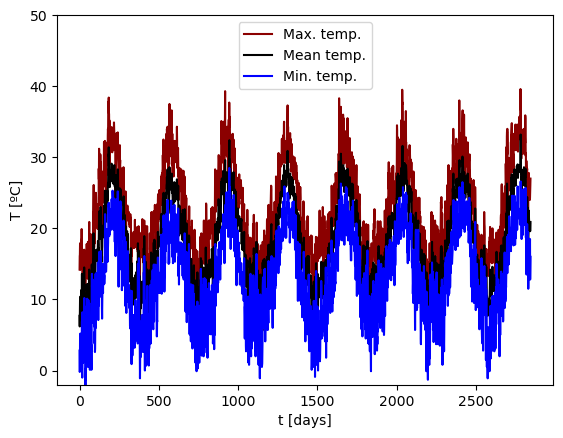

In [13]:
line1, = plt.plot(x_c["tempmax"], color="darkred", label="Max. temp.")
line2, = plt.plot(x_c["temp"], color="black", label="Mean temp.")
line3, = plt.plot(x_c["tempmin"], color="blue", label="Min. temp.")
plt.xlabel("t [days]")
plt.ylabel("T [ºC]")
plt.ylim(-2, 50)
plt.legend(handles=[line1, line2, line3], loc="upper center")
plt.show()

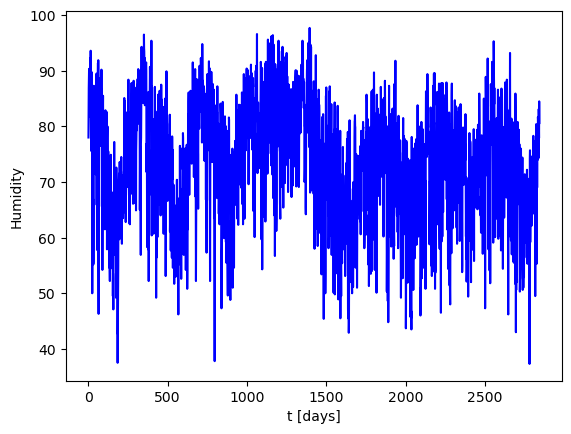

In [14]:
plt.plot(x_c["humidity"], color="blue")
plt.xlabel("t [days]")
plt.ylabel("Humidity")
plt.show()

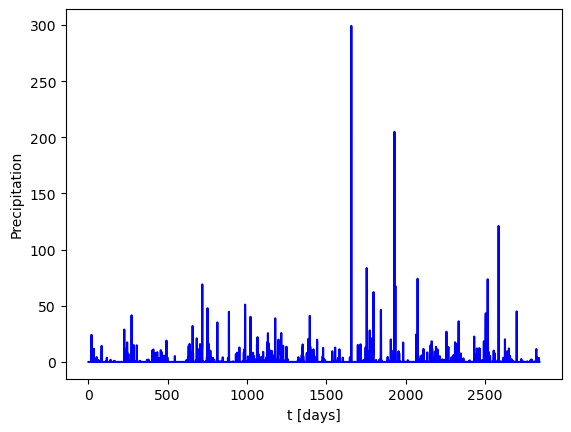

In [15]:
plt.plot(x_c["precip"], color="blue")
plt.xlabel("t [days]")
plt.ylabel("Precipitation")
plt.show()

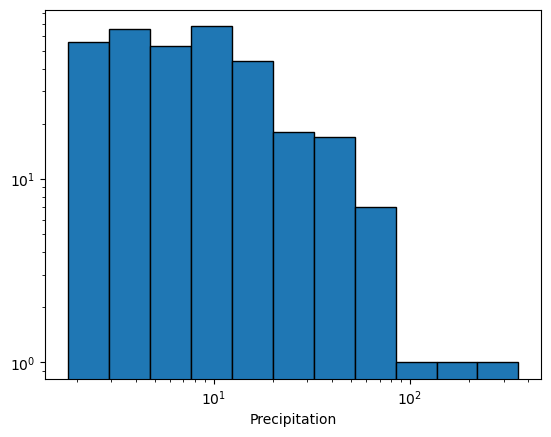

In [16]:
plt.hist(x_c["precip"], bins=np.logspace(1, 10, num=12, base=1.8), edgecolor="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Precipitation")
plt.show()

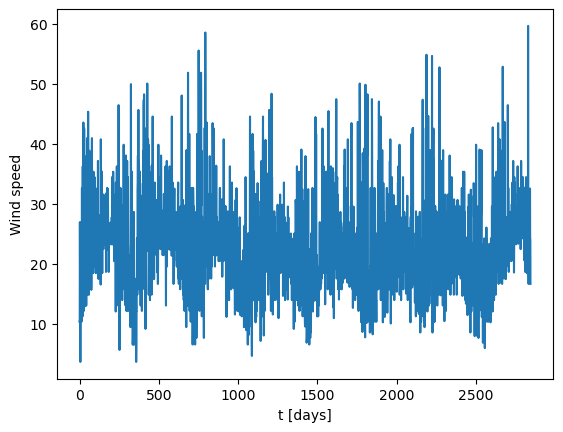

In [17]:
plt.plot(x_c["windspeed"])
plt.xlabel("t [days]")
plt.ylabel("Wind speed")
plt.show()

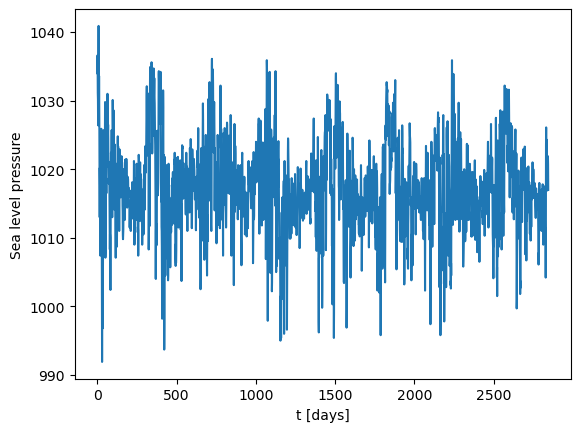

In [18]:
plt.plot(x_c["sealevelpressure"])
plt.xlabel("t [days]")
plt.ylabel("Sea level pressure")
plt.show()

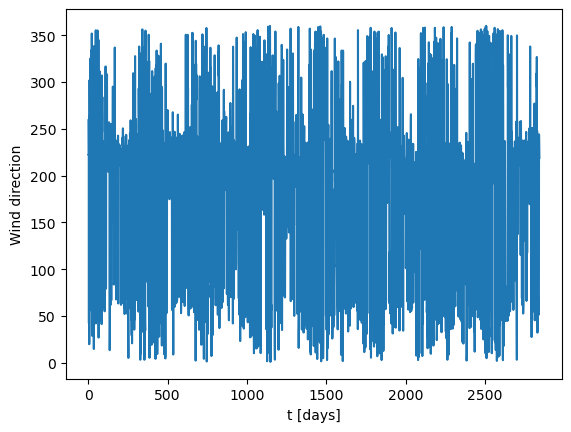

In [19]:
plt.plot(x_c["winddir"])
plt.xlabel("t [days]")
plt.ylabel("Wind direction")
plt.show()

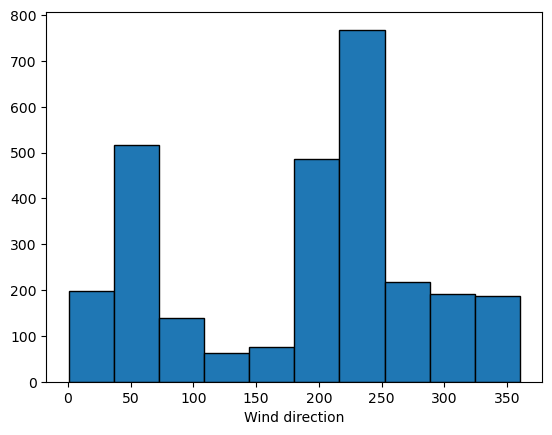

In [20]:
plt.hist(x_c["winddir"], bins=10, edgecolor="black")
plt.xlabel("Wind direction")
plt.show()

# Del histograma podemos ver claramente que el viento dominante está
# aproximadamente a 200-250 grados que es viento del sudoeste
# También hay una cantidad significante de viene del noreste

Empezamos a hacer ya un poco de análisis

In [12]:
sc = StandardScaler()

data_columns = [key for key in x]
data_pros = pd.DataFrame(sc.fit_transform(x), columns=data_columns)

data_pros_city = [None for _ in range(len(x_city))]
for i in range(len(x_city)):
    data_columns = [key for key in x_city[i]]
    data_pros_city[i] = pd.DataFrame(sc.fit_transform(x_city[i]), columns=data_columns)
    
data_pros.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
0,-1.134290,-1.487872,-1.463360,-1.115092,-1.312670,-1.371245,-1.123620,0.667125,-0.232757,-0.600455,...,-0.028668,-0.608776,-0.244405,-0.090335,-0.492032,-0.007659,-0.007659,-0.028668,-0.013266,-0.067356
1,-0.868772,-1.936066,-1.689897,-0.852918,-1.726157,-1.587185,-1.211078,1.082627,-0.232757,-0.600455,...,-0.028668,-0.608776,-0.244405,-0.090335,-0.492032,-0.007659,-0.007659,-0.028668,-0.013266,-0.067356
2,-0.840823,-1.906186,-1.387848,-0.825321,-1.698592,-1.313660,-0.773786,1.227423,-0.232757,-0.600455,...,-0.028668,-0.608776,-0.244405,-0.090335,-0.492032,-0.007659,-0.007659,-0.028668,-0.013266,-0.067356
3,-0.617230,-1.218956,-1.116004,-0.604543,-1.064578,-1.068928,-0.388968,1.365924,-0.232757,-0.600455,...,-0.028668,-0.608776,-0.244405,-0.090335,-0.492032,-0.007659,-0.007659,-0.028668,-0.013266,-0.067356
4,-0.854798,-1.472933,-1.236823,-0.839120,-1.298887,-1.169700,-0.493919,1.441469,-0.232757,-0.600455,...,-0.028668,-0.608776,-0.244405,-0.090335,-0.492032,-0.007659,-0.007659,-0.028668,-0.013266,-0.067356


<h1>Rain prediction</h1>
</br></br>
In this section I will get the data from a day and try to predict if it will rain

In [13]:
list_to_drop = ["precip", "precipprob", "precipcover", "conditions_Clear",
                "conditions_Partially cloudy", "conditions_Rain",
                "conditions_Rain, Partially cloudy",
                "conditions_Snow, Rain, Partially cloudy", "conditions_Snow, Rain"]

x_rain = data_pros.copy()
for key in list_to_drop:
    try:
        x_rain = x_rain.drop([key], axis=1)
    except KeyError:
        pass

y_rain = data.apply(lambda row: row["precip"] > 0.01, axis=1)

x_rain_city = [d_city.copy() for d_city in data_pros_city]
y_rain_city = [None for _ in range(len(data_pros_city))]

for i in range(len(data_pros_city)):
    for key in list_to_drop:
        try:
            x_rain_city[i] = x_rain_city[i].drop([key], axis=1)
        except KeyError:
            pass
    y_rain_city[i] = data_city[i].apply(lambda row: row["precip"] > 0.01, axis=1)

## Support Vector Machine

In [23]:
for i,key in enumerate(x_rain_city[0], start=1):
    print(f"{i}:\t{key}")

1:	tempmax
2:	tempmin
3:	temp
4:	feelslikemax
5:	feelslikemin
6:	feelslike
7:	dew
8:	humidity
9:	windspeed
10:	winddir
11:	sealevelpressure
12:	cloudcover
13:	visibility
14:	solarradiation
15:	solarenergy
16:	uvindex
17:	moonphase
18:	year
19:	month
20:	day
21:	lighthours


In [44]:
# Entrenamos y testamos con todos los datos mezclados
xTrain, xTest, yTrain, yTest = train_test_split(x_rain, y_rain, test_size=0.25, random_state=SEED)

# Entrenamos en una ciudad y testamos en otra
#xTrain, xTest, yTrain, yTest = x_rain_city[1].drop(["snow", "snowdepth"], axis=1), x_rain_city[0], y_rain_city[1], y_rain_city[0]

In [25]:
svm_clf = svm.SVC()
classifier = svm_clf.fit(xTrain, yTrain)
yPred = classifier.predict(xTest)

In [26]:
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))
print(accuracy_score(yTest, yPred))

[[3096  129]
 [ 444  594]]
              precision    recall  f1-score   support

       False       0.87      0.96      0.92      3225
        True       0.82      0.57      0.67      1038

    accuracy                           0.87      4263
   macro avg       0.85      0.77      0.79      4263
weighted avg       0.86      0.87      0.86      4263

0.8655876143560872


In [27]:
kfold = KFold(10, shuffle=True)
cross_val_acc = cross_val_score(classifier, x_rain, y_rain, cv=kfold, scoring="accuracy")
print(cross_val_acc.mean(), cross_val_acc.std())

0.8706082978811283 0.006151381604656984


In [28]:
svm_clf = svm.SVC(C = 20)
classifier = svm_clf.fit(xTrain, yTrain)
yPred = classifier.predict(xTest)

In [29]:
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))
print(accuracy_score(yTest, yPred))

[[3039  186]
 [ 393  645]]
              precision    recall  f1-score   support

       False       0.89      0.94      0.91      3225
        True       0.78      0.62      0.69      1038

    accuracy                           0.86      4263
   macro avg       0.83      0.78      0.80      4263
weighted avg       0.86      0.86      0.86      4263

0.8641801548205489


In [30]:
kfold = KFold(10, shuffle=True)
cross_val_acc = cross_val_score(classifier, x_rain, y_rain, cv=kfold, scoring="accuracy")
print(cross_val_acc.mean(), cross_val_acc.std())

0.874773105888508 0.007700471300682332


### Support Vector Machine con PCA

In [45]:
pca = PCA(n_components=len(x_rain.T)-9)
xTrain_red = pca.fit_transform(xTrain)
xTest_red = pca.transform(xTest)
xTransform_red = pca.transform(x_rain)

In [46]:
svm_clf = svm.SVC()
classifier = svm_clf.fit(xTrain_red, yTrain)
yPred = classifier.predict(xTest_red)

In [47]:
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))
print(accuracy_score(yTest, yPred))

[[3090  135]
 [ 451  587]]
              precision    recall  f1-score   support

       False       0.87      0.96      0.91      3225
        True       0.81      0.57      0.67      1038

    accuracy                           0.86      4263
   macro avg       0.84      0.76      0.79      4263
weighted avg       0.86      0.86      0.85      4263

0.8625381186957541


In [49]:
kfold = KFold(10, shuffle=True)
cross_val_acc = cross_val_score(classifier, xTransform_red, y_rain, cv=kfold, scoring="accuracy")
print(cross_val_acc.mean(), cross_val_acc.std())

0.8660918246527061 0.0043980621038443414


### Ajuste de los hiperparámetros de la Support Vector Machine

In [25]:
valores_C = [20, 30, 40]

best_acc, best_C = 0, None
for valC in valores_C:
    svm_clf_C = svm.SVC(C=valC)
    classifier_C = svm_clf_C.fit(xTrain, yTrain)
    kfold = KFold(10, shuffle=True)
    cross_val_acc = cross_val_score(classifier_C, x_rain, y_rain, cv=kfold, scoring='accuracy')
    if cross_val_acc.mean() > best_acc:
        best_acc = cross_val_acc.mean()
        best_C = valC
    print(f"{valC}:\t{cross_val_acc.mean()}")

print(f"\n\nMejor valor del hiperparámetro C = {best_C}")
#0.01:	0.8449770076962263
#0.1:	0.8627490603444714
#1:	0.8698449740476093
#10:	0.8745976002643427
#20:	0.8745968086131647
#30:	0.8744790246857489
#40:	0.8735409180400093

20:	0.8745968086131647
30:	0.8744790246857489
40:	0.8735409180400093


Mejor valor del hiperparámetro C = 20


In [31]:
bestC = 20

kernels_options = ["linear", "poly", "rbf", "sigmoid"]
for tKernel in kernels_options:
    svm_clf_k = svm.SVC(C=bestC, kernel=tKernel)
    classifier_k = svm_clf_k.fit(xTrain, yTrain)
    kfold = KFold(10, shuffle=True)
    cross_val_acc = cross_val_score(classifier_k, x_rain, y_rain, cv=kfold, scoring='accuracy')
    print(f"{tKernel}:\t{cross_val_acc.mean()} +/- {cross_val_acc.std()}")

linear:	0.8637455426596725 +/- 0.005021919073245671
poly:	0.8687317059738687 +/- 0.009483850620371392
rbf:	0.8747131813363073 +/- 0.009914526783960967
sigmoid:	0.774356490851266 +/- 0.0076317849449653846


In [32]:
for kernel_deg in range(2, 5):
    svm_clf_k = svm.SVC(C=bestC, kernel="poly", degree=kernel_deg)
    classifier_k = svm_clf_k.fit(xTrain, yTrain)
    kfold = KFold(10, shuffle=True)
    cross_val_acc = cross_val_score(classifier_k, x_rain, y_rain, cv=kfold, scoring='accuracy')
    print(f"{kernel_deg}:\t{cross_val_acc.mean()} +/- {cross_val_acc.std()}")

2:	0.8601088004075284 +/- 0.007513247101334206
3:	0.8684385541007531 +/- 0.009251928221067428
4:	0.858876474880564 +/- 0.0101660214675622


[]

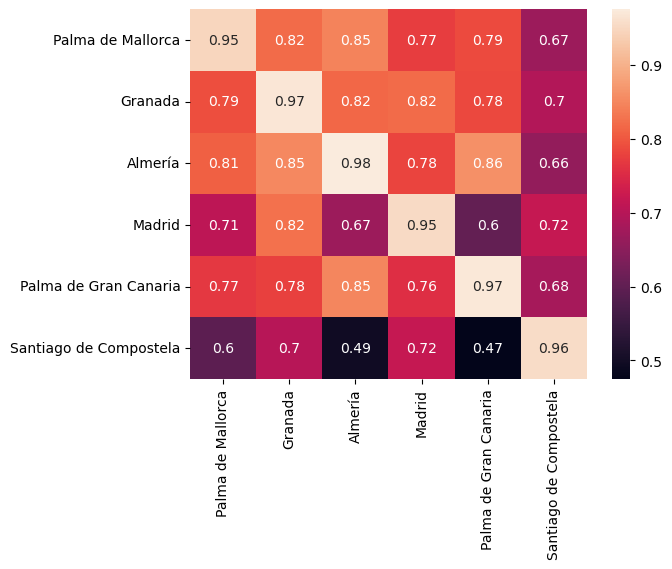

In [16]:
n_cities = len(x_rain_city)

original_keys = x_rain_city[0].keys()
def is_not_original(key):
    return not key in original_keys

accuracies = np.zeros([n_cities, n_cities])
for n_train in range(n_cities):
    for n_pred in range(n_cities):
        keys_to_filter_train = list(filter(is_not_original, x_rain_city[n_train]))
        x_rain_filter_train = x_rain_city[n_train].drop(keys_to_filter_train, axis=1)
        keys_to_filter_pred = list(filter(is_not_original, x_rain_city[n_pred]))
        x_rain_filter_pred = x_rain_city[n_pred].drop(keys_to_filter_pred, axis=1)
        
        xTrain, xTest = x_rain_filter_train, x_rain_filter_pred
        yTrain, yTest = y_rain_city[n_train], y_rain_city[n_pred]
        
        svm_clf = svm.SVC(C=20)
        classifier = svm_clf.fit(xTrain, yTrain)
        yPred = classifier.predict(xTest)
        
        accuracies[n_train, n_pred] = accuracy_score(yTest, yPred)

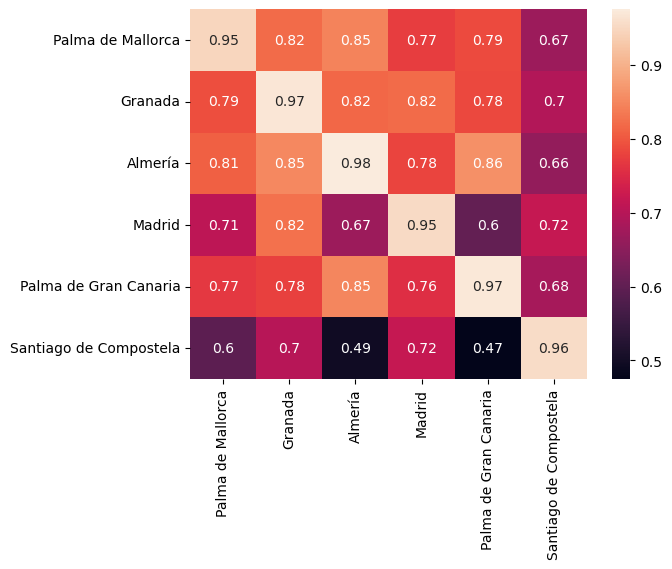

In [17]:
sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades, annot=True)
plt.savefig("SVM_cities_C_20.pdf", dpi=200, bbox_inches="tight")
plt.plot()
plt.show()

In [18]:
accuracies

array([[0.94727592, 0.82003515, 0.84534271, 0.77398946, 0.78629174,
        0.66997167],
       [0.79015817, 0.96871705, 0.81511424, 0.82038664, 0.78383128,
        0.69511331],
       [0.80843585, 0.85061511, 0.97539543, 0.78172232, 0.86080844,
        0.65899433],
       [0.70931459, 0.82495606, 0.66924429, 0.95219684, 0.60316344,
        0.71848442],
       [0.76660808, 0.77785589, 0.84850615, 0.75571178, 0.96977153,
        0.68130312],
       [0.59578207, 0.69982425, 0.49455185, 0.71739895, 0.47486819,
        0.95502833]])

In [21]:
n_cities = len(x_rain_city)
trained_with = np.empty([n_cities, n_cities], dtype=object)
for n_train in range(n_cities):
    for n_pred in range(n_cities):
        trained_with[n_train, n_pred] = ciudades[n_train]

trained_with

array([['Palma de Mallorca', 'Palma de Mallorca', 'Palma de Mallorca',
        'Palma de Mallorca', 'Palma de Mallorca', 'Palma de Mallorca'],
       ['Granada', 'Granada', 'Granada', 'Granada', 'Granada', 'Granada'],
       ['Almería', 'Almería', 'Almería', 'Almería', 'Almería', 'Almería'],
       ['Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid'],
       ['Palma de Gran Canaria', 'Palma de Gran Canaria',
        'Palma de Gran Canaria', 'Palma de Gran Canaria',
        'Palma de Gran Canaria', 'Palma de Gran Canaria'],
       ['Santiago de Compostela', 'Santiago de Compostela',
        'Santiago de Compostela', 'Santiago de Compostela',
        'Santiago de Compostela', 'Santiago de Compostela']], dtype=object)

In [29]:
arr_accuracies = accuracies.flatten()
print(min(arr_accuracies))
print(max(arr_accuracies))
print(np.mean(arr_accuracies))
## Resultados con C = 1
#0.556414762741652
#0.9314586994727593
#0.795341406517517

## Resultados con C = 20
#0.4748681898066784
#0.9753954305799648
#0.7740769068430664

0.4748681898066784
0.9753954305799648
0.7740769068430664


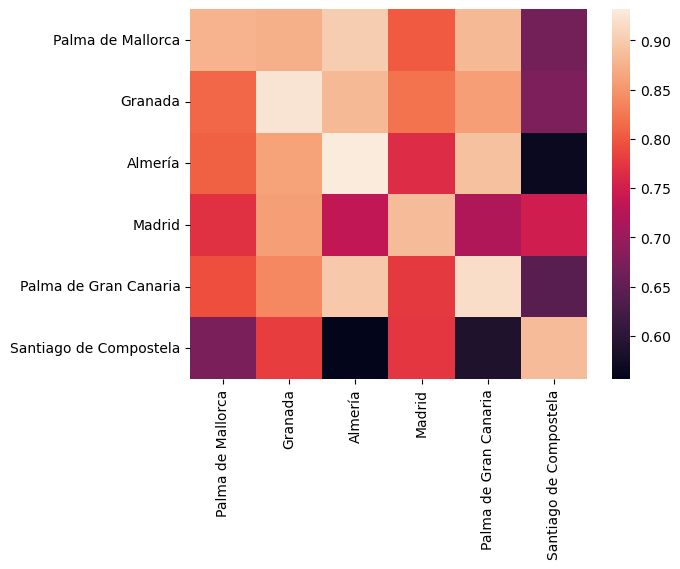

In [29]:
n_cities = len(x_rain_city)

original_keys = x_rain_city[0].keys()
def is_not_original(key):
    return not key in original_keys

accuracies = np.zeros([n_cities, n_cities])
for n_train in range(n_cities):
    for n_pred in range(n_cities):
        keys_to_filter_train = list(filter(is_not_original, x_rain_city[n_train]))
        x_rain_filter_train = x_rain_city[n_train].drop(keys_to_filter_train, axis=1)
        keys_to_filter_pred = list(filter(is_not_original, x_rain_city[n_pred]))
        x_rain_filter_pred = x_rain_city[n_pred].drop(keys_to_filter_pred, axis=1)
        
        xTrain, xTest = x_rain_filter_train, x_rain_filter_pred
        yTrain, yTest = y_rain_city[n_train], y_rain_city[n_pred]
        
        svm_clf = svm.SVC(C=1)
        classifier = svm_clf.fit(xTrain, yTrain)
        yPred = classifier.predict(xTest)
        
        accuracies[n_train, n_pred] = accuracy_score(yTest, yPred)

sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades)
plt.plot()
plt.show()

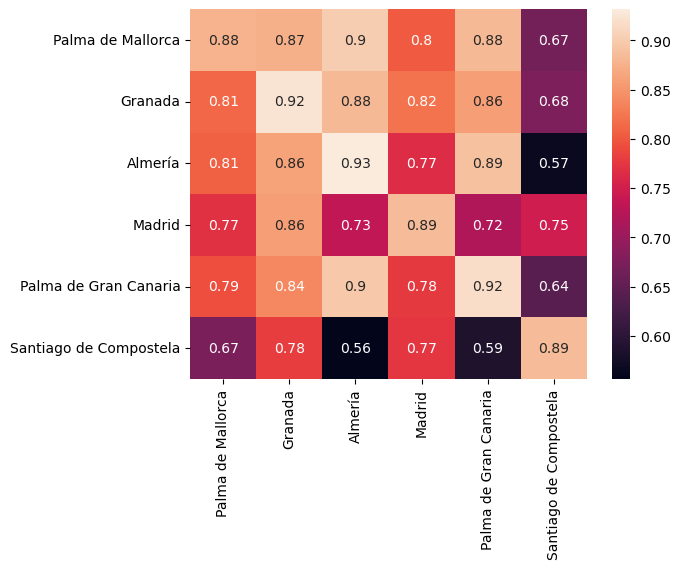

In [30]:
sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades, annot=True)
plt.savefig("SVM_cities_C_1.pdf", dpi=200, bbox_inches="tight")
plt.plot()
plt.show()

In [32]:
arr_accuracies = accuracies.flatten()
print(min(arr_accuracies))
print(max(arr_accuracies))
print(np.mean(arr_accuracies))

0.556414762741652
0.9314586994727593
0.795341406517517


## Logistic Regression

In [16]:
logis_clf = LogisticRegression(max_iter=1000)
classifier = logis_clf.fit(xTrain, yTrain)
yPred = classifier.predict(xTest)

In [17]:
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))
print(accuracy_score(yTest, yPred))

[[3036  189]
 [ 415  623]]
              precision    recall  f1-score   support

       False       0.88      0.94      0.91      3225
        True       0.77      0.60      0.67      1038

    accuracy                           0.86      4263
   macro avg       0.82      0.77      0.79      4263
weighted avg       0.85      0.86      0.85      4263

0.8583157400891391


In [18]:
kfold = KFold(10, shuffle=True)
cross_val_acc = cross_val_score(classifier, x_rain, y_rain, cv=kfold, scoring='accuracy')
print(cross_val_acc.mean(), cross_val_acc.std())

0.8631007599851307 0.009006699913432083


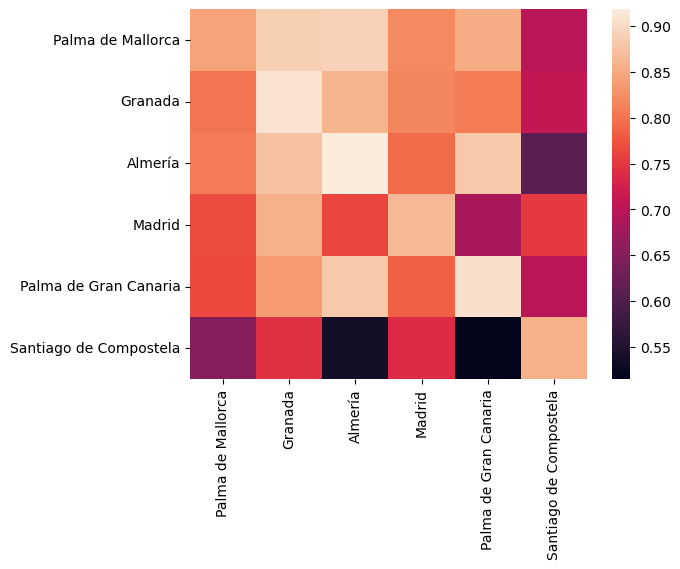

In [22]:
n_cities = len(x_rain_city)

original_keys = x_rain_city[0].keys()
def is_not_original(key):
    return not key in original_keys

accuracies = np.zeros([n_cities, n_cities])
for n_train in range(n_cities):
    for n_pred in range(n_cities):
        keys_to_filter_train = list(filter(is_not_original, x_rain_city[n_train]))
        x_rain_filter_train = x_rain_city[n_train].drop(keys_to_filter_train, axis=1)
        keys_to_filter_pred = list(filter(is_not_original, x_rain_city[n_pred]))
        x_rain_filter_pred = x_rain_city[n_pred].drop(keys_to_filter_pred, axis=1)
        
        xTrain, xTest = x_rain_filter_train, x_rain_filter_pred
        yTrain, yTest = y_rain_city[n_train], y_rain_city[n_pred]
        
        logis_clf = LogisticRegression(max_iter=1000)
        classifier = logis_clf.fit(xTrain, yTrain)
        yPred = classifier.predict(xTest)
        
        accuracies[n_train, n_pred] = accuracy_score(yTest, yPred)

sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades)
plt.plot()
plt.show()

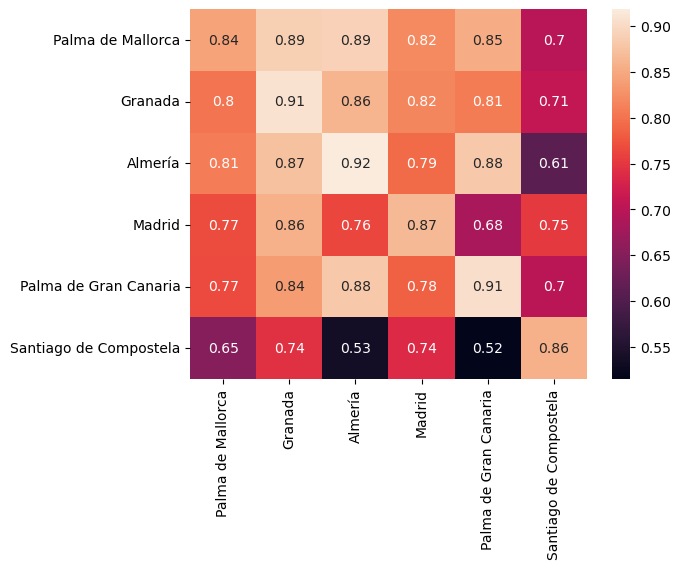

In [23]:
sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades, annot=True)
plt.savefig("LR_cities_C_1.pdf", dpi=200, bbox_inches="tight")
plt.plot()
plt.show()

In [39]:
arr_accuracies = accuracies.flatten()
print(min(arr_accuracies))
print(max(arr_accuracies))
print(np.mean(arr_accuracies))

0.5152899824253075
0.9181019332161687
0.7884390076024237


[]

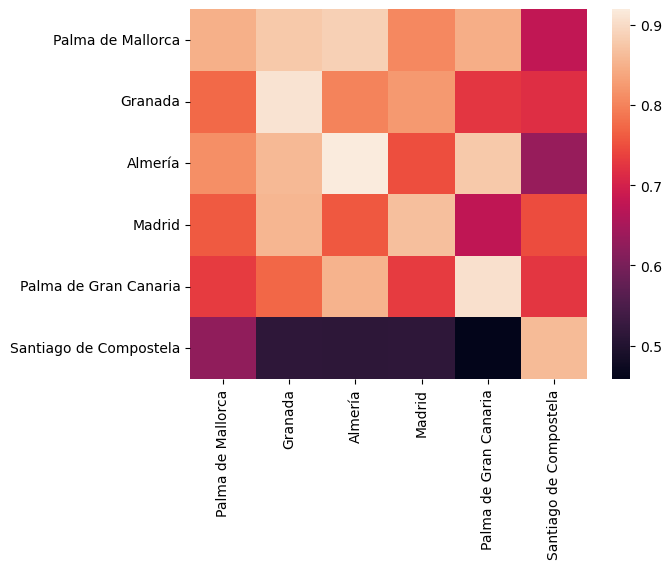

In [37]:
n_cities = len(x_rain_city)

original_keys = x_rain_city[0].keys()
def is_not_original(key):
    return not key in original_keys

accuracies = np.zeros([n_cities, n_cities])
for n_train in range(n_cities):
    for n_pred in range(n_cities):
        keys_to_filter_train = list(filter(is_not_original, x_rain_city[n_train]))
        x_rain_filter_train = x_rain_city[n_train].drop(keys_to_filter_train, axis=1)
        keys_to_filter_pred = list(filter(is_not_original, x_rain_city[n_pred]))
        x_rain_filter_pred = x_rain_city[n_pred].drop(keys_to_filter_pred, axis=1)
        
        xTrain, xTest = x_rain_filter_train, x_rain_filter_pred
        yTrain, yTest = y_rain_city[n_train], y_rain_city[n_pred]
        
        logis_clf = LogisticRegression(C=40, max_iter=1000)
        classifier = logis_clf.fit(xTrain, yTrain)
        yPred = classifier.predict(xTest)
        
        accuracies[n_train, n_pred] = accuracy_score(yTest, yPred)

sns.heatmap(accuracies, xticklabels=ciudades, yticklabels=ciudades)
plt.plot()

In [38]:
arr_accuracies = accuracies.flatten()
print(min(arr_accuracies))
print(max(arr_accuracies))
print(np.mean(arr_accuracies))

0.45834797891036905
0.9198594024604569
0.7617320821944635


### Ajuste de hiperparámetros para Logistic Regression

In [23]:
valores_C = [100_000, 1_000_000]

best_acc, best_C = 0, None
for valC in valores_C:
    logis_clf_C = LogisticRegression(C=valC, max_iter=1000)
    classifier_C = logis_clf_C.fit(xTrain, yTrain)
    kfold = KFold(10, shuffle=True)
    cross_val_acc = cross_val_score(classifier_C, x_rain, y_rain, cv=kfold, scoring='accuracy')
    if cross_val_acc.mean() > best_acc:
        best_acc = cross_val_acc.mean()
        best_C = valC
    print(f"{valC}:\t{cross_val_acc.mean()}")

print(f"\n\nMejor valor del hiperparámetro C = {best_C}")
#1:	0.8629253232001982
#10:	0.8631597896273044
#20:	0.8632178555202181
#25:	0.8633935332424656
#30:	0.863570002615891
#40:	0.8638632577478557
#50:	0.8631005878870486
#60:	0.8631591356545923
#70:	0.8635695207412608
#80:	0.8639806286398745
#90:	0.8635103534206214
#100:	0.8637458524362204
#120:	0.8628084686024259
#140:	0.863218165296766
#160:	0.8635695895804938
#180:	0.8635117646248951
#200:	0.8637448542673439

100000:	0.8639217366761665
1000000:	0.8630414205664092


Mejor valor del hiperparámetro C = 100000


# PCA

In [15]:
xTrain, xTest, yTrain, yTest = train_test_split(x_rain, y_rain, test_size=0.25, random_state=SEED)

In [16]:
pca = PCA(n_components=2)
xTrain_red = pca.fit_transform(xTrain)
xTest_red = pca.transform(xTest)
xTransform_red = pca.transform(x_rain)

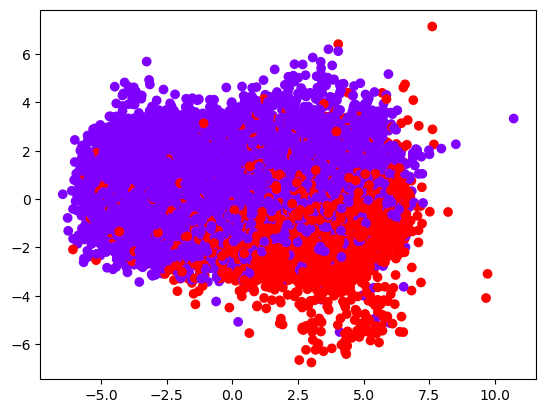

In [17]:
plt.scatter(xTransform_red[:,0], xTransform_red[:,1], c=y_rain, cmap="rainbow")
plt.show()

In [18]:
svm_clf = svm.SVC(C=0.05, kernel="linear")
classifier = svm_clf.fit(xTrain, yTrain)
yPred = classifier.predict(x_rain)

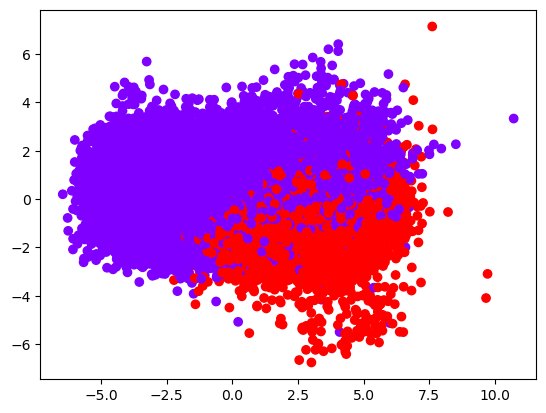

In [19]:
plt.scatter(xTransform_red[:,0], xTransform_red[:,1], c=yPred, cmap="rainbow")
plt.show()

In [20]:
logis_clf = LogisticRegression(C=0.001, max_iter=1000)
classifier = logis_clf.fit(xTrain, yTrain)
yPred = classifier.predict(x_rain)

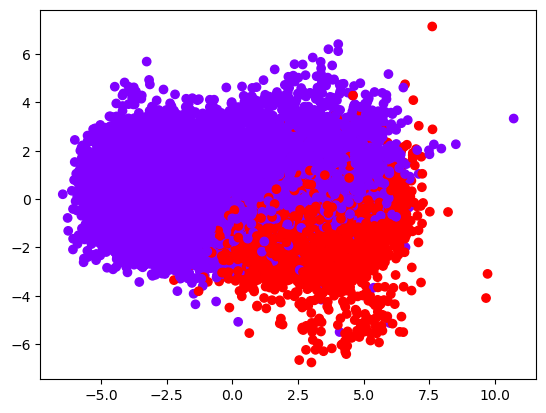

In [21]:
plt.scatter(xTransform_red[:,0], xTransform_red[:,1], c=yPred, cmap="rainbow")
plt.show()

# Autocorrelations

In [24]:
n_city = 0

y_rain_precip = pd.DataFrame()
y_rain_precip["precip"] = y_rain_city[n_city]
data_rain = pd.concat([y_rain_precip, x_rain_city[n_city]], axis=1)
n_series = len(data_rain.T)

zerolag_ccf = np.zeros([n_series, n_series])
for (i, key1) in enumerate(data_rain, start=0):
    for (j, key2) in enumerate(data_rain, start=0):
        zerolag_ccf[i,j]  = sm.tsa.stattools.ccf(data_rain[key1], data_rain[key2],
                                                 adjusted=False)[0]

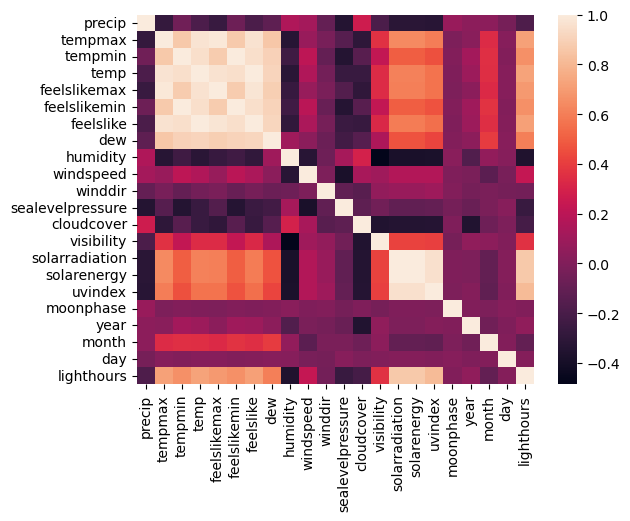

In [25]:
sns.heatmap(zerolag_ccf, xticklabels=data_rain.keys(), yticklabels=data_rain.keys())
plt.show()

In [26]:
zerolag_ccf_avg = np.zeros([n_series, n_series])
n_cities = len(x_rain_city)

original_keys = x_rain_city[0].keys()
def is_not_original(key):
    return not key in original_keys

for n_city in range(n_cities):
    y_rain_precip = pd.DataFrame()
    y_rain_precip["precip"] = y_rain_city[n_city]
    keys_to_filter = list(filter(is_not_original, x_rain_city[n_city]))
    x_rain_filter = x_rain_city[n_city].drop(keys_to_filter, axis=1)
    
    data_rain = pd.concat([y_rain_precip, x_rain_filter], axis=1)
    n_series = len(data_rain.T)
 
    for (i, key1) in enumerate(data_rain, start=0):
        for (j, key2) in enumerate(data_rain, start=0):
            zerolag_ccf_avg[i,j] += sm.tsa.stattools.ccf(data_rain[key1], data_rain[key2],
                                                     adjusted=False)[0]

zerolag_ccf_avg /= n_cities

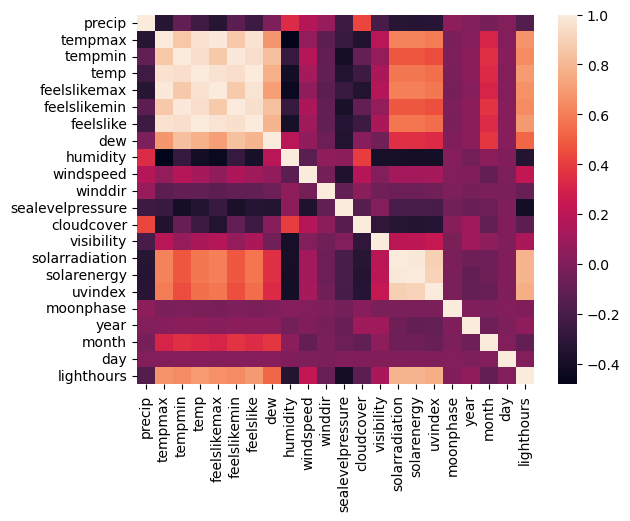

In [27]:
sns.heatmap(zerolag_ccf_avg, xticklabels=data_rain.keys(), yticklabels=data_rain.keys())
plt.savefig("AverageCorrelation.pdf", dpi=150, bbox_inches="tight")
plt.show()

In [85]:
print("Correlations with the dichotomic variable \"precip\"\n")
for (key, v) in zip(data_rain.keys(), zerolag_ccf_avg[0]):
    v_str = str(v).rjust(40-len(key), ' ')
    print(f"{key}:{v_str}")

Correlations with the dichotomic variable "precip"

precip:                0.9999999999999999
tempmax:              -0.3306773645556502
tempmin:             -0.10854782837372956
temp:                 -0.2391350592921548
feelslikemax:         -0.3267102619713097
feelslikemin:        -0.12464928282348776
feelslike:           -0.24211387561899733
dew:                -0.012996643804668445
humidity:              0.3358388285636286
windspeed:            0.18030174719806605
winddir:              0.08178296068014647
sealevelpressure:    -0.24487012262241195
cloudcover:           0.42719993891486113
visibility:          -0.20433055102678876
solarradiation:      -0.33008186711486837
solarenergy:         -0.33249432230999887
uvindex:             -0.32294265141340195
moonphase:            0.04846582326805629
year:                0.007059527157301105
month:               -0.03476353111615755
day:                  0.00397659023776515
lighthours:          -0.16343286030080453


# Comparar las distribuciones de lluvia

In [50]:
n_cities = len(ciudades)
ks_pvalues = np.zeros([n_cities, n_cities])
for i in range(n_cities):
    for j in range(n_cities):
        ks_pvalues[i, j] = sp.stats.kstest(data_city[i]["precip"], data_city[j]["precip"]).pvalue

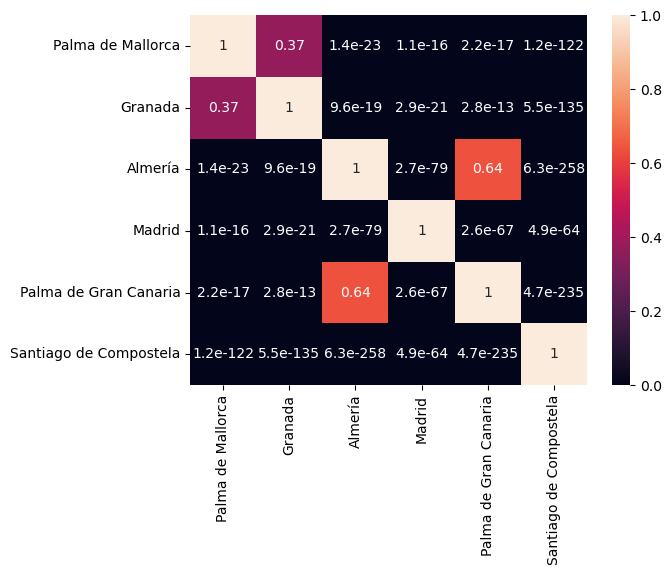

In [54]:
sns.heatmap(ks_pvalues, xticklabels=ciudades, yticklabels=ciudades, annot=True)
plt.savefig("KSpvaluesCities.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [22]:
ks_pvalues_arr = ks_pvalues.flatten()
n_compat = (sum(1 for p in ks_pvalues_arr if p > 0.05)-n_cities)//2
print(n_compat)

2


Este resultado es muy curioso y coincide en ciertos casos con lo visto para nuestro clasificador de lluvia, nuestro clasificador funciona relativamente bien en ciudades cuya distribución de lluvia es similar.

# Exercise final lesson

In [28]:
# I already have the data well-scaled in x_rain
pca = PCA(n_components=6)
x_trans = pca.fit_transform(x_rain)
print(x_trans[0])

[ 4.56192728  1.17929684  0.06932975  1.95564712  0.15190516 -0.69473088]


In [29]:
# Covariant matrix of data
covmat = np.cov(x_rain.T)

In [30]:
# Get eigenvalues and eigenvectors
eigvals, eigvects = np.linalg.eigh(covmat)

In [31]:
D = len(eigvals)
sum_eigvals = sum(eigvals)
partial_sum = np.zeros(D+1)
s = 0
for i in range(D-1, -1, -1):
    partial_sum[D-1-i] = s
    s += eigvals[i]
partial_sum[-1] = s

partial_sum /= sum_eigvals

In [32]:
partial_sum

array([0.        , 0.31370603, 0.40571898, 0.46395132, 0.51142981,
       0.55289162, 0.59186458, 0.62856933, 0.6650256 , 0.70085393,
       0.7365302 , 0.77207736, 0.80734481, 0.84115406, 0.87414368,
       0.90269864, 0.92787579, 0.94826503, 0.96572098, 0.98084801,
       0.98844121, 0.99364425, 0.99810188, 0.9986671 , 0.99919557,
       0.99956638, 0.99979447, 0.99997658, 1.        ])

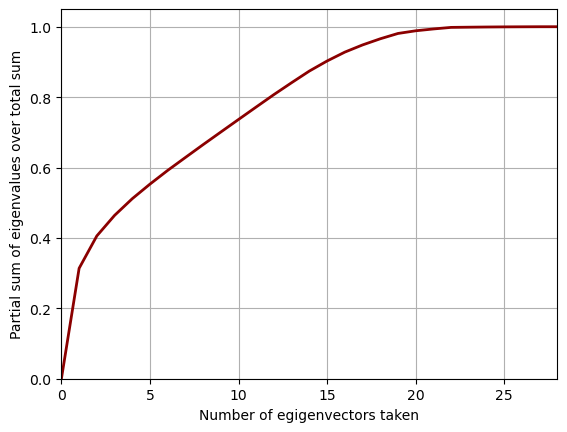

In [42]:
plt.plot([i for i in range(D+1)], partial_sum, lw=2, c="darkred")
plt.xlabel("Number of egigenvectors taken")
plt.ylabel("Partial sum of eigenvalues over total sum")
plt.xlim(0, 28)
plt.ylim(0, 1.05)
plt.grid()
plt.savefig("PCAError.pdf", dpi=150, bbox_inches="tight")
plt.show()